# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, isnan, when, sum
from pyspark.sql import Window
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, PCA, StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

We want to get an overview about the dataframe containing the traffic data:

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



How many entries are there in the data set?

In [5]:
df.count()

286500

check for missing values in "userId", "sessionId" within the data set:

In [6]:
df.filter(df.sessionId=='').count()

0

In [7]:
df.filter(df.userId=='').count()

8346

=> no missing values in "sessionId", but 8346 missing in "userId". They are traffic-data of user, which at this stage didn't have a userId.

In [8]:
df_valid = df.filter(df.userId!='')

In [9]:
df_valid.count()

278154

we want to remove unused columns...

In [10]:
df_valid = df_valid.drop('sessionId','auth','method','itemInSession','userAgent','lastName','firstName','artist','song','length')

Now we want to dig deeper into the data. From the column "page", which describes the interaction with the userID, we extract usefull data:
In this context, we define labels to:  
- count churns from the page column to have a target for the model,  
- count thumbs ups/ downs from the page column to get an idea, if users like the music provided,  
- count add-friends/ add-to-playlist from the page column to get an idea, if users would recomend the service to friend and if they use playlists, which is a indication for a long-term-contact  , 
- count, how many times a user switches between the levels ('paid', 'free')

In [11]:
# define user-defined-functions to extract information about the user-behaviour:
cancelation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
thumbs_up = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())  
thumbs_down = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())  
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())  
add_to_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())  
roll_advert = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())  
level_i = udf(lambda x: 1 if x == "paid" else 0, IntegerType())  

# add columns with this data to the data frame
df_valid = df_valid.withColumn("churn", cancelation("page"))
df_valid = df_valid.withColumn("thumbs_up", thumbs_up("page"))
df_valid = df_valid.withColumn("thumbs_down", thumbs_down("page"))
df_valid = df_valid.withColumn("add_friend", add_friend("page"))
df_valid = df_valid.withColumn("add_to_playlist", add_to_playlist("page"))
df_valid = df_valid.withColumn("roll_advert", roll_advert("page"))
df_valid = df_valid.withColumn("level_i", level_i("level"))
df_valid = df_valid.withColumn("ts1", df_valid.ts)
df_valid = df_valid.withColumn("ts2", df_valid.ts)

Now we want to aggregate the data to the userID:  
- sum churns to see, if a user has churned (perhaps more than 1 time),  
- sum thumbs ups/ downs / add-friends/ add-to-playlist to see, how many times a user used "thumbs up/ down/ add-friends/ add-to-playlist",  
- extract the dates of first, last and "average" time to get an idea, how long users used the service and if the usage was more intensive in the beginning or the end,
- consider the gender and location of the user:

In [12]:
df_valid_userId = df_valid.groupBy('userId')\
    .agg({'churn':'sum',\
          'gender':'max',\
          'page':'count',\
          'thumbs_up':'sum',\
          'thumbs_down':'sum',\
          'add_friend':'sum',\
          'add_to_playlist':'sum',\
          'roll_advert':'sum',\
          'location':'max',\
          'level_i':'sum',\
          'ts':'max',\
          'ts1':'min',\
          'ts2':'avg'})\
    .withColumnRenamed('sum(churn)', 'churns') \
    .withColumnRenamed('sum(thumbs_up)', 'thumbs_ups') \
    .withColumnRenamed('sum(thumbs_down)', 'thumbs_downs') \
    .withColumnRenamed('sum(add_friend)', 'add_friend') \
    .withColumnRenamed('sum(add_to_playlist)', 'add_to_playlist') \
    .withColumnRenamed('sum(roll_advert)', 'roll_advert') \
    .withColumnRenamed('max(location)', 'location') \
    .withColumnRenamed('sum(level_i)', 'level_i') \
    .withColumnRenamed('count(page)', 'accesses') \
    .withColumnRenamed('max(ts)', 'ts_max') \
    .withColumnRenamed('min(ts1)', 'ts_min') \
    .withColumnRenamed('avg(ts2)', 'ts_avg') \
    .withColumnRenamed('max(gender)', 'gender')

In [13]:
df_valid_userId.count()

225

How many actions does a user have on average?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44f8113ac8>]], dtype=object)

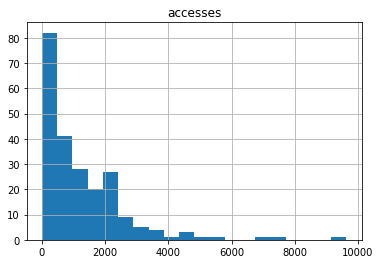

In [14]:
df_valid_userId.select("accesses").toPandas().hist(bins=20)

How big is the churn by user?

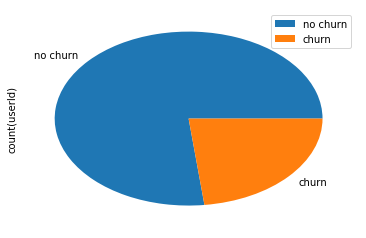

In [15]:
df_valid_userId.groupBy('churns').agg({'userId':'count'}).toPandas().replace({0: 'no churn', 1: 'churn'}).set_index('churns').plot.pie(y='count(userId)')

In [16]:
df_valid_userId.groupBy('churns').agg({'userId':'count'}).toPandas().replace({0: 'no churn', 1: 'churn'}).set_index('churns')

,count(userId)
churns,
no churn,173
churn,52


Which gender are the users?

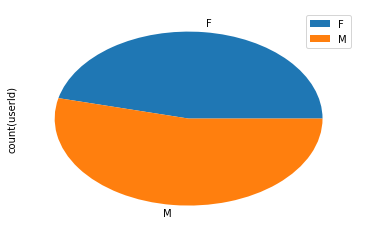

In [17]:
df_valid_userId.groupBy('gender')\
    .agg({'userId':'count'}).toPandas().set_index('gender').plot.pie(y='count(userId)')

Do the users like the music there are provided?  
How many "Thumbs-ups" are there, how many "Thumbs-downs"

In [18]:
df_valid_userId.agg(sum("thumbs_ups")).show()
df_valid_userId.agg(sum("thumbs_downs")).show()

+---------------+
|sum(thumbs_ups)|
+---------------+
|          12551|
+---------------+

+-----------------+
|sum(thumbs_downs)|
+-----------------+
|             2546|
+-----------------+



Where do the users come from?

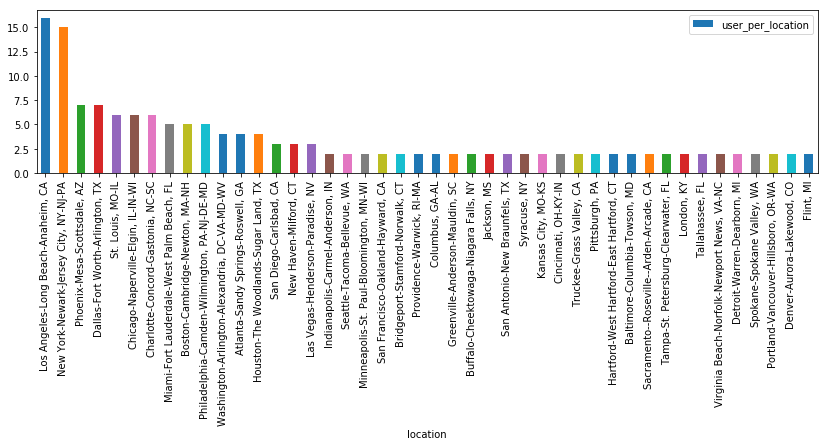

In [19]:
temp = df_valid_userId.groupBy('location')\
    .agg({'userId':'count'})\
    .sort("count(userId)", ascending=False)\
    .withColumnRenamed("count(userId)", 'user_per_location')
temp.filter(temp.user_per_location>1).toPandas().plot.bar(x='location', y='user_per_location', figsize=(14,3))

hist: relative: how often has user-status changed?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f44f1da9278>]], dtype=object)

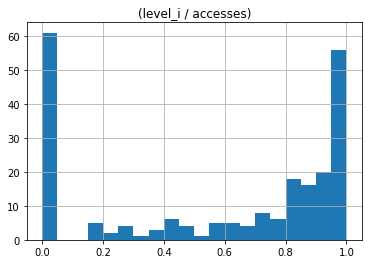

In [20]:
df_valid_userId.select(df_valid_userId.level_i/ df_valid_userId.accesses).toPandas().hist(bins=20)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### check for features:  
We want to find out, which given features do have a significant correlation to the target "churn".  
In addition, we try to create more features with significant correlation from the given data.  
  
Gender:  
we want to see, if femal users tend more to resign than male:

In [21]:
df_valid_gen_ch = df_valid_userId\
    .select(['gender','churns']) \
    .groupBy(['gender','churns']) \
    .agg({'gender':'count'}) \
    .sort(['gender',desc('count(gender)')])

In [22]:
df_valid_gen_ch.show()

+------+------+-------------+
|gender|churns|count(gender)|
+------+------+-------------+
|     F|     0|           84|
|     F|     1|           20|
|     M|     0|           89|
|     M|     1|           32|
+------+------+-------------+



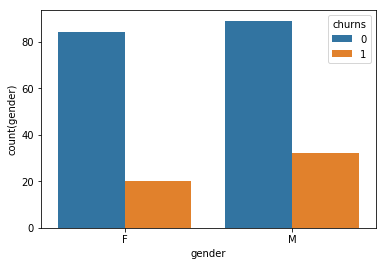

In [23]:
sns.barplot(x="gender", y="count(gender)", hue="churns", data=df_valid_gen_ch.toPandas())

it looks like males do resign a little bit more often than females, So lets take 'gender' as a feature.

#### check for features:  
status:

it looks like males do churn a little bit more often than females, So lets take 'gender' as a feature.

#### check for features:  
number of actions: The idea is, that users, which uses the service very often, tend more not to resign:

In [24]:
df_valid_gen_ch = df_valid_userId\
    .select(['accesses','churns']) \
    .groupBy('churns') \
    .agg({'accesses':'avg'}) 

In [25]:
df_valid_gen_ch.show()

+------+------------------+
|churns|     avg(accesses)|
+------+------------------+
|     0|1348.4971098265896|
|     1| 862.7692307692307|
+------+------------------+



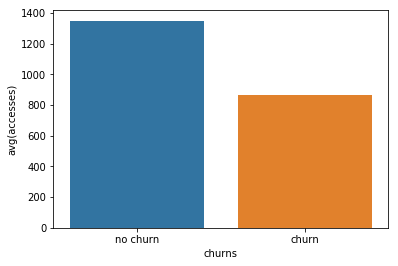

In [26]:
sns.barplot(x="churns", y="avg(accesses)", data=df_valid_gen_ch.toPandas().replace({0: 'no churn', 1: 'churn'}))

#### check for features:  
activity per period:  
the idea is, that also users, which uses the service more frequently (activity per period in contrast to activity only), tend more  to not resign:

In [27]:
df_valid_userId = df_valid_userId.withColumn("acc_per_time", df_valid_userId.accesses / (df_valid_userId.ts_max - df_valid_userId.ts_min))

In [28]:
df_valid_userId.printSchema()

root
 |-- userId: string (nullable = true)
 |-- thumbs_ups: long (nullable = true)
 |-- location: string (nullable = true)
 |-- accesses: long (nullable = false)
 |-- ts_max: long (nullable = true)
 |-- ts_avg: double (nullable = true)
 |-- roll_advert: long (nullable = true)
 |-- ts_min: long (nullable = true)
 |-- level_i: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- churns: long (nullable = true)
 |-- thumbs_downs: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- acc_per_time: double (nullable = true)



In [29]:
df_valid_gen_ch = df_valid_userId\
    .select(['acc_per_time','churns']) \
    .groupBy('churns') \
    .agg({'acc_per_time':'avg'}) 

In [30]:
df_valid_gen_ch.show()

+------+--------------------+
|churns|   avg(acc_per_time)|
+------+--------------------+
|     0|5.998008275603489E-7|
|     1|1.244870878822003...|
+------+--------------------+



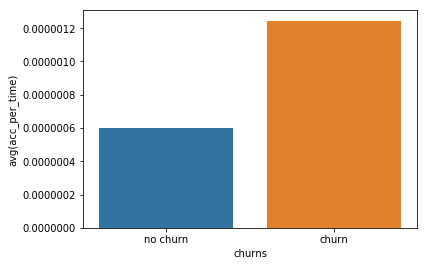

In [31]:
sns.barplot(x="churns", y="avg(acc_per_time)", data=df_valid_gen_ch.toPandas().replace({0: 'no churn', 1: 'churn'}))

#### check for features:  
change of activity over time:  
by calculating the ratio of mean to range we can see if the user has more accesses in the 1st. half or in the 2nd half of his registration periode. That means, the quastion is, if the users activity changes over time. If the activity lowers, this would be an indicator, that the user looses interest.

In [32]:
df_valid_userId = df_valid_userId.withColumn("mean_median_ratio", df_valid_userId.ts_avg / (df_valid_userId.ts_max - df_valid_userId.ts_min))

In [33]:
df_valid_gen_ch = df_valid_userId\
    .select(['mean_median_ratio','churns']) \
    .groupBy('churns') \
    .agg({'mean_median_ratio':'avg'}) 

In [34]:
df_valid_gen_ch.show()

+------+----------------------+
|churns|avg(mean_median_ratio)|
+------+----------------------+
|     0|    32180.598203378395|
|     1|    43774.620661879024|
+------+----------------------+



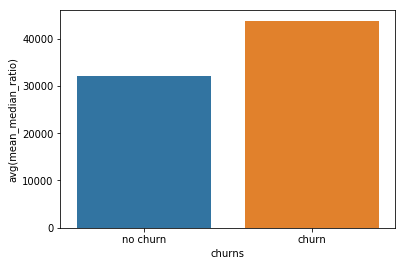

In [35]:
sns.barplot(x="churns", y="avg(mean_median_ratio)", data=df_valid_gen_ch.toPandas().replace({0: 'no churn', 1: 'churn'}))

#### check for features:  
relative "thumbs_ups -  thumbs_downs"-activity:  
by calculating the ratio of the difference between how often the user made "thumbs_ups"-activity and "thumbs_down"-activity to general activity we can see if the user likes the music being provided by the service.

In [36]:
#thumbs = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())  

In [37]:
df_valid_userId = df_valid_userId.withColumn("thumbs_ratio", ((df_valid_userId.thumbs_ups -  df_valid_userId.thumbs_downs)/ df_valid_userId.accesses))

In [38]:
df_valid_gen_ch = df_valid_userId\
    .select(['thumbs_ratio','churns']) \
    .groupBy('churns') \
    .agg({'thumbs_ratio':'avg'}) 

In [39]:
df_valid_gen_ch.show()

+------+--------------------+
|churns|   avg(thumbs_ratio)|
+------+--------------------+
|     0| 0.03591336424676769|
|     1|0.028063337903091568|
+------+--------------------+



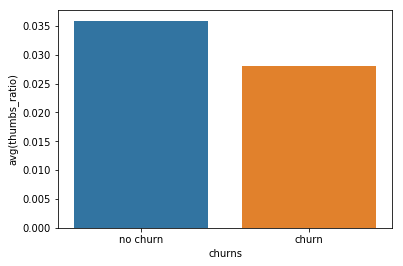

In [40]:
sns.barplot(x="churns", y="avg(thumbs_ratio)", data=df_valid_gen_ch.toPandas().replace({0: 'no churn', 1: 'churn'}))

#### check for features:  
relative "add_friend"-activity:  
by calculating the ratio of how often the user made "add_friend"-activity to general activity we can see if the user likes the service and involves a friend.

In [41]:
#thumbs = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())  

In [42]:
df_valid_userId = df_valid_userId.withColumn("add_friend_ratio", (df_valid_userId.add_friend / df_valid_userId.accesses))

In [43]:
df_valid_userId.printSchema()

root
 |-- userId: string (nullable = true)
 |-- thumbs_ups: long (nullable = true)
 |-- location: string (nullable = true)
 |-- accesses: long (nullable = false)
 |-- ts_max: long (nullable = true)
 |-- ts_avg: double (nullable = true)
 |-- roll_advert: long (nullable = true)
 |-- ts_min: long (nullable = true)
 |-- level_i: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- churns: long (nullable = true)
 |-- thumbs_downs: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- acc_per_time: double (nullable = true)
 |-- mean_median_ratio: double (nullable = true)
 |-- thumbs_ratio: double (nullable = true)
 |-- add_friend_ratio: double (nullable = true)



In [44]:
df_valid_gen_ch = df_valid_userId\
    .select(['add_friend_ratio','churns']) \
    .groupBy('churns') \
    .agg({'add_friend_ratio':'avg'}) 

In [45]:
df_valid_gen_ch.show()

+------+---------------------+
|churns|avg(add_friend_ratio)|
+------+---------------------+
|     0| 0.017133419241856383|
|     1| 0.015496216774773667|
+------+---------------------+



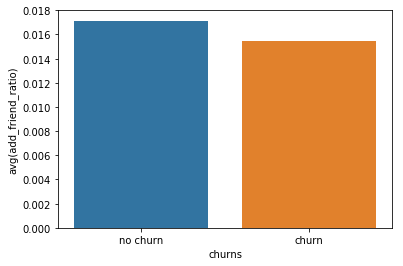

In [46]:
sns.barplot(x="churns", y="avg(add_friend_ratio)", data=df_valid_gen_ch.toPandas().replace({0: 'no churn', 1: 'churn'}))

#### check for features:  
relative "add_to_playlist"-activity:  
by calculating the ratio of how often the user made "add_to_playlist"-activity to general activity we can see if the user build playlists, which he  or she can use in the future, which only make snse if you stay with the service.

In [47]:
df_valid_userId = df_valid_userId.withColumn("add_to_playlist_ratio", (df_valid_userId.add_to_playlist / df_valid_userId.accesses))

In [48]:
df_valid_gen_ch = df_valid_userId\
    .select(['add_to_playlist_ratio','churns']) \
    .groupBy('churns') \
    .agg({'add_to_playlist_ratio':'avg'}) 

In [49]:
df_valid_gen_ch.show()

+------+--------------------------+
|churns|avg(add_to_playlist_ratio)|
+------+--------------------------+
|     0|      0.022119638174335828|
|     1|      0.022944399944692835|
+------+--------------------------+



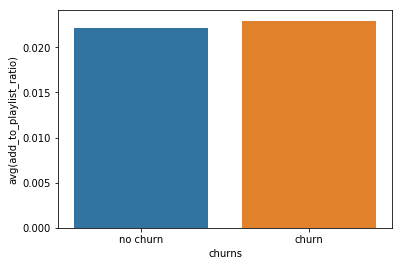

In [50]:
sns.barplot(x="churns", y="avg(add_to_playlist_ratio)", data=df_valid_gen_ch.toPandas().replace({0: 'no churn', 1: 'churn'}))

Put all features together into one vector and call it 'features'. Call the target 'churn' 'label'.

In [51]:
# rename to features and target and split up data into train and validation data:
train,validation = df_valid_userId.withColumnRenamed('churns', 'label').randomSplit([0.8, 0.2], seed=42)

In [52]:
# transform string "gender" to numercal "gender_num"
indexer = StringIndexer(inputCol="gender", outputCol="gender_num")
train = indexer.fit(train).transform(train)

In [53]:
# transform features into vector
assembler = VectorAssembler(inputCols=["accesses","gender_num","acc_per_time","thumbs_ratio","mean_median_ratio", "add_friend_ratio","add_to_playlist_ratio"], outputCol="features_ns")
train = assembler.transform(train)

In [54]:
# transform to Standard
scaler = StandardScaler(inputCol="features_ns", outputCol="features1", withStd=True)
train = scaler.fit(train).transform(train)

In [55]:
# create PCA-model, keep 6 features):
pca = PCA(k=6, inputCol="features1", outputCol="features")

# fit PCA-model:
pca_model = pca.fit(train)

# transform features:
train = pca_model.transform(train)

# calculate explained Variances
ev = pca_model.explainedVariance

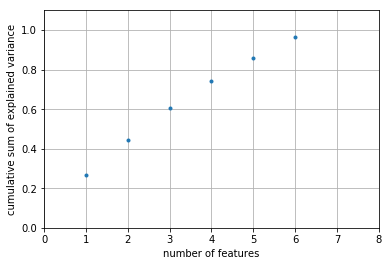

In [56]:
# plot explained Variances:
plt.plot(range(1,ev.size+1),ev.cumsum(),'.')
plt.xlabel('number of features')
plt.ylabel('cumulative sum of explained variance')
plt.axis([0, 8, 0, 1.1])
plt.grid()

We can see, that the explained Variance is distributed relativly evenly. So, if we want to keep more than 90% of the explained variance, we should keep all features. PCA as dimention reduction doesn't make sense in this context.  
However, for comparability reasons, we will keep the PCA also in upcomming approaches.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Overview  
We will make the following approaches:
#### "manual" modelling Logistic-Regression-model
- data preparation
  - transform gender to numerical values, so that it can be used in the model
  - transform all features into a vector called "features_ns"
  - standatize features
- create, fit and test Principal Component Analysis  
  - try to reduce the dimention of features using PCA
- create, fit and test Logistic-Regression-model  

#### optimizing parameters for Logistic-Regression-model using pipeline

Now we create and train a Logistic Regression model:

In [57]:
# create model:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

# fit model:
lrmodel = lr.fit(train)

# calculate accuracy on training data:
lrmodel.summary.accuracy


0.7643979057591623

So, the accuracy is not to bad.
Now we want to build a pipline.

As we change the train data within the data preperation, we have to reset the data for the new approach:

In [58]:
train,validation = df_valid_userId.withColumnRenamed('churns', 'label').randomSplit([0.8, 0.2], seed=42)

We now put together all the steps descibed above into a pipeline:

In [59]:
pipeline_lr = Pipeline(stages=[indexer, assembler, scaler, pca, lr])

to improve the results, we will now try to find better parameters for the Logistic Regression model using a Cross Validator on a parameter grid:

In [60]:
# define parameter grid:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter,[5,10,20]) \
    .addGrid(lr.regParam,[0,0.1,0.5]) \
    .build()

# define evaluator
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# define CrossValidator
crossval = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score_evaluator,
                          numFolds=3)

# fit CrossValidator:
cv_model_lr = crossval.fit(train)

# test CrossValidator on val data:
results = cv_model_lr.transform(validation)

# evaluate F1 on val:
f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
print('The F1 score on the evaluator set is {:.2%}'.format(f1_score)) 

The F1 score on the evaluator set is 64.81%


The best set of parameter is:

In [61]:
cv_model_lr.getEstimatorParamMaps()[np.argmax(cv_model_lr.avgMetrics)]

{Param(parent='LogisticRegression_4712717fd2ae', name='maxIter', doc='max number of iterations (>= 0).'): 5,
 Param(parent='LogisticRegression_4712717fd2ae', name='regParam', doc='regularization parameter (>= 0).'): 0.0}

The metrices are:

In [62]:
cv_model_lr.avgMetrics

[0.7074375251525273,
 0.6903327168200345,
 0.6712010801817516,
 0.6966770699842217,
 0.6903327168200345,
 0.668282113242225,
 0.6966770699842217,
 0.6903327168200345,
 0.668282113242225]

now we want to built a similar pipline, but this time with a RandomForestClassifier and compare both approaches:

In [63]:
rf = RandomForestClassifier(numTrees=3, maxDepth=3,seed=42)

In [64]:
pipeline_rf = Pipeline(stages=[indexer, assembler, scaler, pca, rf])

reset data

In [65]:
train,validation = df_valid_userId.withColumnRenamed('churns', 'label').randomSplit([0.8, 0.2], seed=42)

In [66]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[30,50,80]) \
    .addGrid(rf.maxDepth,[3,4,10,20]) \
    .build()

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score_evaluator,
                          numFolds=3)

cv_model_rf = crossval.fit(train)

results = cv_model_rf.transform(validation)

f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
print('The F1 score on the evaluator set is {:.2%}'.format(f1_score)) 

The F1 score on the evaluator set is 72.63%


In [67]:
# best model from cross validation:
best_model = cv_model_rf.bestModel

In [68]:
# best parameters:
cv_model_rf.getEstimatorParamMaps()[np.argmax(cv_model_rf.avgMetrics)]

{Param(parent='RandomForestClassifier_30e2142d2966', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
 Param(parent='RandomForestClassifier_30e2142d2966', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3}

In [69]:
# metrics of all parameters:
cv_model_rf.avgMetrics

[0.7643019423414541,
 0.734190257510902,
 0.7009989391862903,
 0.7719494950719603,
 0.7531228169389741,
 0.7661293383006982,
 0.7762226987906244,
 0.7607906439537435,
 0.7411332416734633]

now we want to built a similar pipline, but this time with a Support Vector Machine and compare to the other approaches:

In [70]:
svm = LinearSVC(maxIter=10, regParam=0.1)

In [71]:
pipeline_svm = Pipeline(stages=[indexer, assembler, scaler, pca, svm])

reset data

In [72]:
train,validation = df_valid_userId.withColumnRenamed('churns', 'label').randomSplit([0.8, 0.2], seed=42)

In [73]:
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter,[5,10,20]) \
    .addGrid(svm.regParam,[0,0.1,0.5]) \
    .build()

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval = CrossValidator(estimator=pipeline_svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_score_evaluator,
                          numFolds=3)

cv_model_svm = crossval.fit(train)

results = cv_model_svm.transform(validation)

f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
print('The F1 score on the evaluator set is {:.2%}'.format(f1_score)) 

The F1 score on the evaluator set is 66.27%


In [74]:
# best model from cross validation:
best_model = cv_model_svm.bestModel

In [75]:
# best parameters:
cv_model_svm.getEstimatorParamMaps()[np.argmax(cv_model_svm.avgMetrics)]

{Param(parent='LinearSVC_0feb2d3dcf66', name='maxIter', doc='max number of iterations (>= 0).'): 5,
 Param(parent='LinearSVC_0feb2d3dcf66', name='regParam', doc='regularization parameter (>= 0).'): 0.0}

In [76]:
# metrics of all parameters:
cv_model_svm.avgMetrics

[0.6797357535352604,
 0.6797357535352604,
 0.6797357535352604,
 0.6797357535352604,
 0.6797357535352604,
 0.6797357535352604,
 0.6797357535352604,
 0.6797357535352604,
 0.6797357535352604]

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [77]:
import pyspark; print(pyspark.__version__)

2.4.3


In [78]:
import numpy; print(numpy.__version__)

1.12.1


In [79]:
import seaborn; print(seaborn.__version__)

0.8.1


In [80]:
import pandas; print(pandas.__version__)

0.23.3


In [81]:
import matplotlib; print(matplotlib.__version__)

2.1.0


In [82]:
from platform import python_version

print(python_version())

3.6.3


In [83]:
print(matplotlib.__version__)


2.1.0
